In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import root_pandas as rpd

import scipy.constants

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import gridspec

import seaborn as sns
sns.set_palette("deep", desat=.8)
sns.set_context("notebook", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 4, 
                        "ytick.major.size": 4, 
                        "axes.linewidth": 1.35, 
                        "axes.grid": True, 
                        "grid.color": '.7', 
                        "grid.linestyle": "-"})

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
## adjust the filename to the output file you generated using Kassiopeia
filename = '~/kasper/install/output/Kassiopeia/QuadrupoleTrapSimulation_exact.root'
tree = 'component_step_world_DATA'
branches = ['position_y','position_z','time','kinetic_energy','electric_potential']

exact_data = rpd.read_root(filename,tree,columns=branches)

In [3]:
## this is the fit function we use to get the magnetron frequency
def nsignal_y(x,a,f,phi):
    return a*np.cos(f*x+phi)

Here we calculate the relative difference between the total energy  
of the electron in the Trap as a function of time E(t) and its initial energy E(0):  
$\frac{E(t)-E(0)}{E(0)}$.  
As we can see the relative deviation stays for this track below $10^{-11}$.

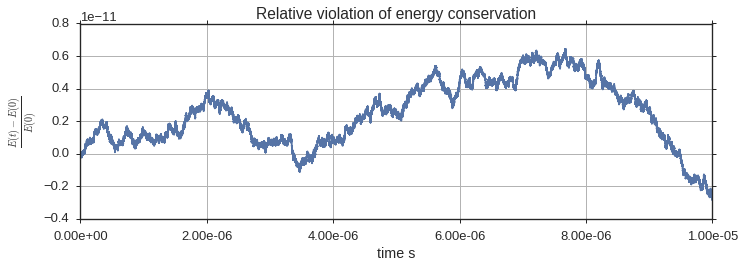

In [49]:
e = exact_data.kinetic_energy-exact_data.electric_potential
fsize = 7.
f = plt.figure(figsize=(fsize*scipy.constants.golden,fsize*0.5))
ax1 = plt.subplot()
ax1.plot(exact_data.time, (e-e[0])/((e[0])))
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.set_xlabel('time s')
ax1.set_ylabel(r'$\frac{E(t)-E(0)}{E(0)}$')
ax1.set_title('Relative violation of energy conservation')
plt.show()
#del e

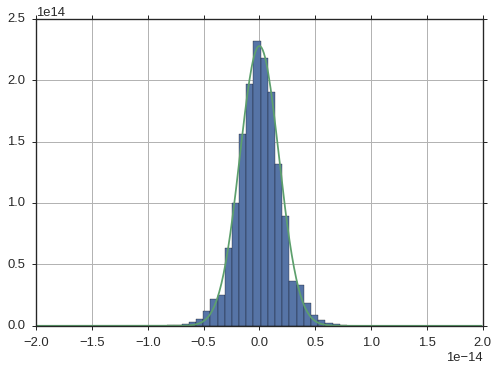

In [119]:
from scipy.stats import norm

earr = np.array(e)
plt.hist(earr[1:]-earr[:-1],bins=50,normed=True)
rv = norm(loc = 0., scale = 0.7*.25e-14)
x = np.arange(-2.e-14, 2.e-14, 1.e-16)

#plot the pdfs of these normal distributions 
plt.plot(x, rv.pdf(x))
#plt.xlim(-2.e-14,2.e-14)
#plt.ylim(0.,1600000)
plt.show()

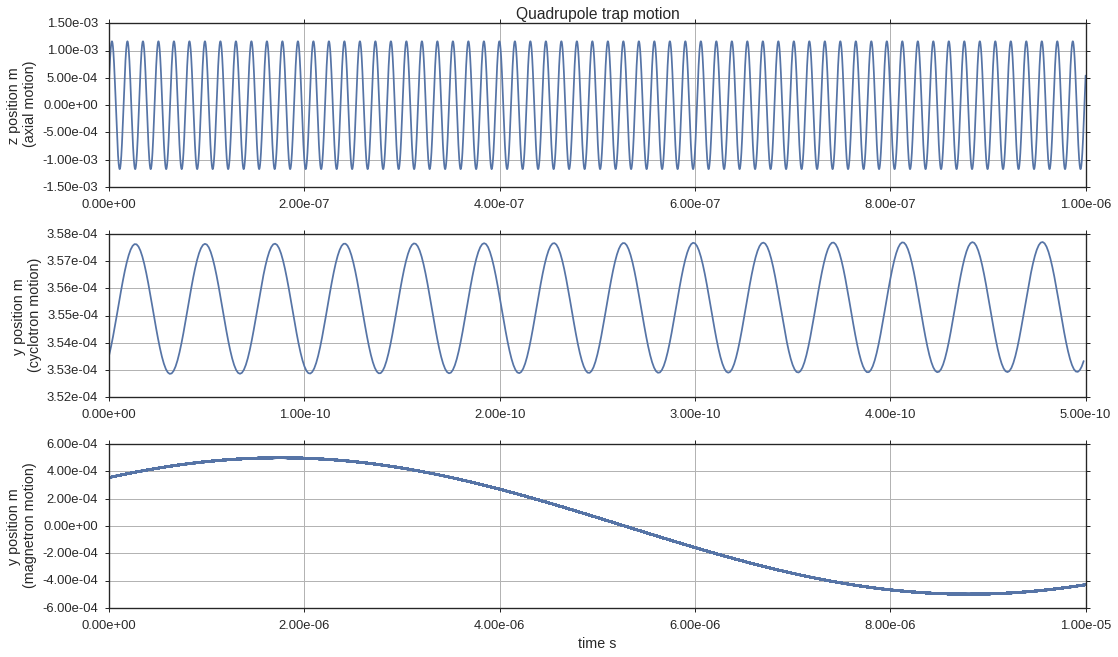

In [5]:
f = plt.figure(figsize=(9.*scipy.constants.golden,9.))
gs = gridspec.GridSpec(3, 1, height_ratios=[0.5, 0.5, 0.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
plt.tight_layout()

t = exact_data.time[:1000000]
z = exact_data.position_z[:1000000]

ax1.plot(t,z)
ax1.set_title('Quadrupole trap motion')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.set_ylabel('z position m\n (axial motion)')

t = exact_data.time
y = exact_data.position_y

cosfit_y_magnetron = scipy.optimize.curve_fit(nsignal_y, t, y,p0=[5.e-4,4.02e+5,-0.5,])

ax3.plot(t,y)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax3.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax3.set_xlabel('time s')
ax3.set_ylabel('y position m\n (magnetron motion)')

t = exact_data.time[:500]
y = exact_data.position_y[:500]

ax2.plot(t,y)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax2.set_ylabel('y position m\n (cyclotron motion)')


plt.show()

In [43]:
t = exact_data.time
y = exact_data.position_y
y_corr = np.array(y-nsignal_y(t,*(cosfit_y_magnetron[0])))
series = np.array(t[((y_corr[:-1]*y_corr[1:]) < 0.)])
f_count = 1./((series[1:]-series[:-1]).mean())*np.pi
print('Trap cyclotron frequency: ', '%.12e' % f_count, 'Hz')
#plt.plot(np.array(t),y_corr)
#plt.show()

Trap cyclotron frequency:  1.758812826568e+11 Hz


/usr/lib64/python3.5/site-packages/pandas/core/internals.py:215: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000000 but corresponding boolean dimension is 9999999
  return self.values[slicer]
/usr/lib64/python3.5/site-packages/pandas/indexes/base.py:1267: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000000 but corresponding boolean dimension is 9999999
  result = getitem(key)


In [44]:
zarray = np.array(exact_data.position_z)
tarray = np.array(exact_data.time)
tarray[1:][(zarray[:-1]*zarray[1:] < 0.)]
f_z = 1./(tarray[(zarray[:-1]*zarray[1:] < 0.)][1:]-tarray[(zarray[:-1]*zarray[1:] < 0.)][:-1]).mean()*np.pi
print('Trap Axial frequency: ' '%.8e' % f_z, 'Hz')

Trap Axial frequency: 3.95881745e+08 Hz


/usr/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000000 but corresponding boolean dimension is 9999999


In [8]:
#m_t5plus = 2*6.032099*1.66053886e-27+5.00735626e-27
gamma = np.sqrt(1+2.*exact_data.kinetic_energy.mean()*scipy.constants.electron_volt/scipy.constants.electron_mass/(scipy.constants.c**2))
fc = scipy.constants.e/(scipy.constants.m_e)/(gamma)*1.

In [113]:
print('Mean energy of the electron: ', exact_data.kinetic_energy.mean(), ' eV')
print('Gamma factor: ', gamma)
print('Calculated free cyclotron Frequency:       ', fc)
print('Free cyclotron frequency from simulation : ',np.sqrt(f_count**2+cosfit_y_magnetron[0][1]**2+f_z**2) )
accuracy = np.sqrt(f_count**2+cosfit_y_magnetron[0][1]**2+f_z**2)/(fc)-1.
print('Accuracy: ',accuracy)
print('Number of simulated cyclotron periods: ', '%.6e' % (exact_data.time.max()*fc))

Mean energy of the electron:  0.805703170958  eV
Gamma factor:  1.00000157672
Calculated free cyclotron Frequency:        175881731468.0
Free cyclotron frequency from simulation :  175881728191.0
Accuracy:  -1.86321319484e-08
Number of simulated cyclotron periods:  1.758817e+06
